importing libraries

In [41]:
from keras.datasets import mnist
from matplotlib import pyplot
import numpy as np

1. Load MNIST dataset.

In [42]:
#loading
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
 
#shape of dataset
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(Y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(Y_test.shape))
 


X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


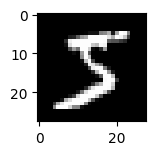

In [43]:
#plotting
for i in range(1):  
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))
    pyplot.show()

2. Subset your data to use only class 0 and class1 for the next steps.

In [44]:
Train_indx = np.array([])
Test_indx =np.array([])

for i in range(len(Y_train)-1):
    if(Y_train[i]==0 or Y_train[i]==1):
        Train_indx = np.append(Train_indx, i )

for i in range(len(Y_test)-1):
    if(Y_test[i]==0 or Y_test[i]==1):
        Test_indx = np.append(Test_indx, i )

Train_indx = Train_indx.astype(int)
Test_indx = Test_indx.astype(int)

X_train = X_train[Train_indx]
X_test = X_test[Test_indx]
Y_train = Y_train[Train_indx]
Y_test = Y_test[Test_indx]


3. Standardize your dataset

In [45]:
mean_train = np.mean(X_train, axis=0)
std_train = np.std(X_train, axis=0)
std_train[std_train == 0] = 1e-9
X_train = (X_train - mean_train) / std_train

mean_test = np.mean(X_test, axis=0)
std_test = np.std(X_test, axis=0)
std_test[std_test == 0] = 1e-9
X_test = (X_test - mean_test) / std_test

X_data = np.concatenate((X_train, X_test), axis=0)
y_data = np.concatenate((Y_train, Y_test), axis=0)

X_data = X_data.reshape(X_data.shape[0],-1)

4. Divide data into training and validation set using 10-fold cross validation method

In [46]:
# Split data into k folds
def k_folds_split(X, y, k):
    n_samples = len(X)
    fold_size = n_samples // k
    X_folds = []
    y_folds = []
    
    # Shuffle the data
    permuted_indices = np.random.permutation(n_samples)
    X_shuffled = X[permuted_indices]
    y_shuffled = y[permuted_indices]
    
    # Split the data into k folds
    for i in range(k):
        X_fold = X_shuffled[i * fold_size : (i + 1) * fold_size]
        y_fold = y_shuffled[i * fold_size : (i + 1) * fold_size]
        X_folds.append(X_fold)
        y_folds.append(y_fold)
    
    return X_folds, y_folds

# Train the model using k-fold cross validation
def k_fold_cross_validation(X, y, k, model):
    X_folds, y_folds = k_folds_split(X, y, k)
    scores = []
    
    for i in range(k):
        X_train = np.concatenate([X_folds[j] for j in range(k) if j != i])
        y_train = np.concatenate([y_folds[j] for j in range(k) if j != i])
        X_val = X_folds[i]
        y_val = y_folds[i]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        sc = model.score(y_val, y_pred)
        scores.append(sc)
        
    return np.mean(scores)


5. Implement Logistic Regression with different values for learning rate

In [47]:
class Logistic_Regression():
    
    
    # declaring learning rate & number of iterations (Hyperparametes)
    def __init__(self, learning_rate, no_of_iterations):
        
        self.learning_rate = learning_rate
        self.no_of_iterations = no_of_iterations
        
        
    # fit function to train the model with dataset
    def fit(self, X, Y):
        
        # number of data points in the dataset (number of rows)  -->  m
        # number of input features in the dataset (number of columns)  --> n
        self.m, self.n = X.shape
        
        #initiating weight & bias value
        self.w = np.zeros(self.n)
        self.b = 0
        self.X = X
        self.Y = Y
        
        # implementing Gradient Descent for Optimization
        for i in range(self.no_of_iterations):
            self.update_weights()       
        
    def update_weights(self):
        # Y_hat formula (sigmoid function)
        Y_hat = 1 / (1 + np.exp( - (self.X.dot(self.w) + self.b ) ))    
        
        # derivaties
        dw = (1/self.m)*np.dot(self.X.T, (Y_hat - self.Y))
        
        db = (1/self.m)*np.sum(Y_hat - self.Y)
        
        # updating the weights & bias using gradient descent
        self.w = self.w - self.learning_rate * dw
        
        self.b = self.b - self.learning_rate * db
      
    # Sigmoid Equation & Decision Boundary
    def predict(self, X):
        Y_pred = 1 / (1 + np.exp( - (X.dot(self.w) + self.b ) ))
        Y_pred = np.where( Y_pred > 0.5, 1, 0)
        return Y_pred
    

    def score(self,y,y_hat):
        tp,tn,fp,fn = 0,0,0,0
        for i in range(len(y)):
            if y[i] == 1 and y_hat[i] == 1:
                tp += 1
            elif y[i] == 1 and y_hat[i] == 0:
                fn += 1
            elif y[i] == 0 and y_hat[i] == 1:
                fp += 1
            elif y[i] == 0 and y_hat[i] == 0:
                tn += 1
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        score = 2*precision*recall/(precision+recall)
        return score


6. Report difference accuracy for the different learning rate.

In [48]:
values_of_learning_rate = [1 , 0.1 , 0.01 , 0.001 , 0.0001]

for curr_val in values_of_learning_rate : 
    model = Logistic_Regression(curr_val , 1000)
    scores = k_fold_cross_validation(X_data,y_data,10,model)
    print(f"Average score of Learning rate {curr_val} :" , scores)



Average score of Learning rate 1 : 0.9989276078075375
Average score of Learning rate 0.1 : 0.9989203142972262
Average score of Learning rate 0.01 : 0.9986142806799736
Average score of Learning rate 0.001 : 0.9968422376831365
Average score of Learning rate 0.0001 : 0.9950641933522848
